# Basic regression: Predict Cross Section F

Using `'phi_x'`

https://www.tensorflow.org/tutorials/keras/regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf # Version 2.9.1
from tensorflow import keras
from tensorflow.keras import layers
np.set_printoptions(precision=3, suppress=True)

### Get the data

In [2]:
column_names = ['Set', 'index', 'k', 'QQ', 'x_b', 't', 'phi_x', 'F', 'sigmaF', 'varF', 'F1', 'F2', 'dvcs']

raw_dataset = pd.read_csv('BKM_pseudodata.txt', skiprows=1, names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,Set,index,k,QQ,x_b,t,phi_x,F,sigmaF,varF,F1,F2,dvcs
10300,229,40,24.0,3.47114,0.179473,-0.569082,328,0.012515,0.000626,0.05,0.378711,0.485848,0.001287
10301,229,41,24.0,3.47114,0.179473,-0.569082,336,0.015971,0.000799,0.05,0.378711,0.485848,0.001287
10302,229,42,24.0,3.47114,0.179473,-0.569082,344,0.019880,0.000994,0.05,0.378711,0.485848,0.001287
10303,229,43,24.0,3.47114,0.179473,-0.569082,352,0.021967,0.001098,0.05,0.378711,0.485848,0.001287
10304,229,44,24.0,3.47114,0.179473,-0.569082,360,0.025392,0.001270,0.05,0.378711,0.485848,0.001287


### Split the data into training and test sets

HELP: Should I randomly generate training data?

In [3]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('F')
test_labels = test_features.pop('F')

### Inspect the data

All of the paterns do not look random, so rows indicate they are functions of each other.

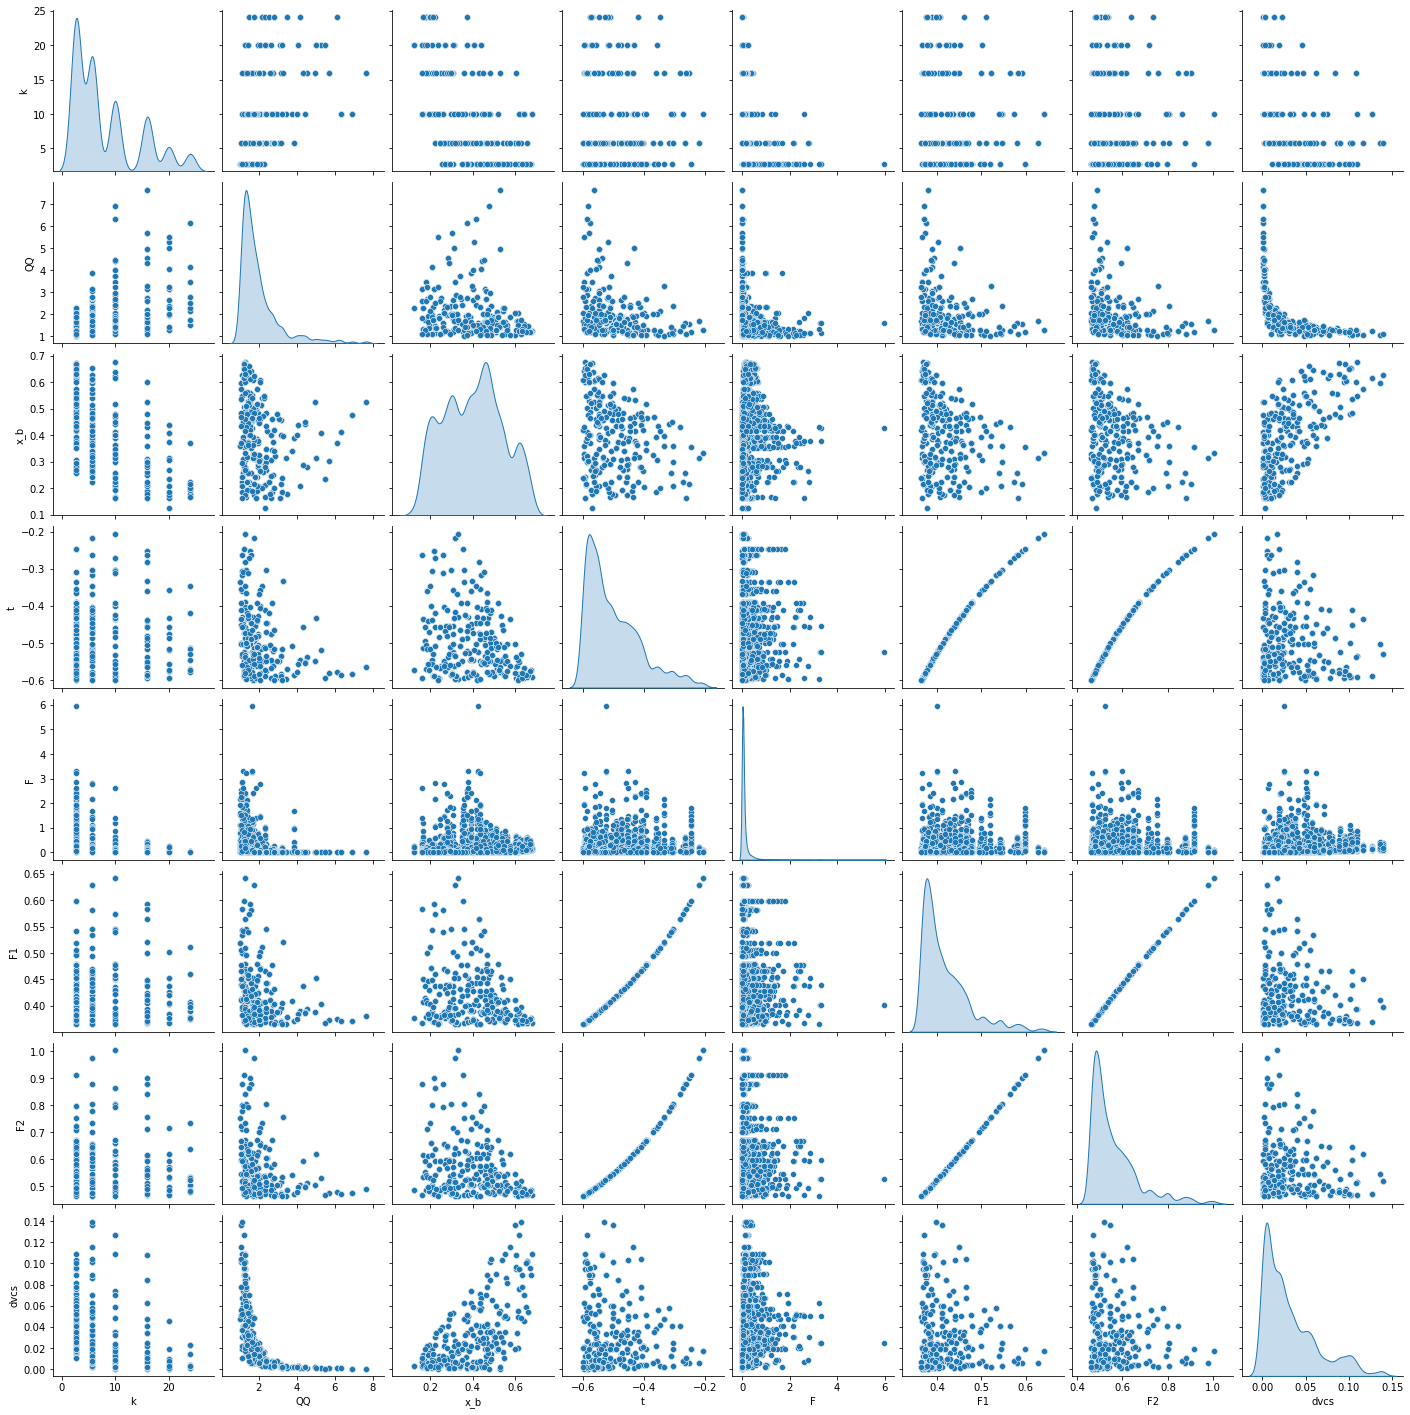

In [4]:
sns.pairplot(train_dataset[['k', 'QQ', 'x_b', 't', 'F', 'F1', 'F2', 'dvcs']], diag_kind='kde')

### Overall statistics

In [5]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Set,8244.0,115.154173,6.611571e+01,1.000000,58.000000,115.000000,172.000000,229.000000
index,8244.0,21.990660,1.297212e+01,0.000000,11.000000,22.000000,33.000000,44.000000
k,8244.0,8.219675,6.173730e+00,2.750000,2.750000,5.750000,10.000000,24.000000
QQ,8244.0,2.000060,1.108356e+00,1.015420,1.286590,1.640380,2.270980,7.653070
x_b,8244.0,0.400395,1.375271e-01,0.124668,0.289411,0.402482,0.501062,0.677932
t,8244.0,-0.499407,8.818205e-02,-0.599976,-0.571495,-0.523862,-0.447489,-0.206039
phi_x,8244.0,183.925279,1.037770e+02,8.000000,96.000000,184.000000,272.000000,360.000000
F,8244.0,0.092915,2.259224e-01,0.000398,0.010876,0.027898,0.078604,5.953220
sigmaF,8244.0,0.004646,1.129612e-02,0.000020,0.000544,0.001395,0.003930,0.297661
varF,8244.0,0.050000,7.209948e-15,0.050000,0.050000,0.050000,0.050000,0.050000


## Normalization

In [6]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Set,115.154173,6.611571e+01
index,21.990660,1.297212e+01
k,8.219675,6.173730e+00
QQ,2.000060,1.108356e+00
x_b,0.400395,1.375271e-01
t,-0.499407,8.818205e-02
phi_x,183.925279,1.037770e+02
F,0.092915,2.259224e-01
sigmaF,0.004646,1.129612e-02
varF,0.050000,7.209948e-15


In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1) # Normalization layer
normalizer.adapt(np.array(train_features)) # Fit the state of the preprocessing later to the data
print(normalizer.mean.numpy()) # Calculate mean and variance and store them in the later

2022-06-16 11:50:46.738092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[115.154  21.991   8.22    2.      0.4    -0.499 183.925   0.005   0.05
    0.418   0.56    0.032]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [8]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[98.    0.    5.75  3.14  0.46 -0.54  8.    0.    0.05  0.4   0.51  0.  ]]

Normalized: [[-0.26 -1.7  -0.4   1.03  0.42 -0.4  -1.7  -0.25 -0.22 -0.43 -0.43 -0.88]]


## Linear regression

### Linear regression with one variable

Single-variable linear regression to predict `'F'` from `'phi_x'`.
NOTE: `'k'`, `'QQ'`, `'x_b'`, and `'t'` are unknown kinematic variables and `'F1'`, `'F2'`, `'dvcs'` are known kinematic variables.

Step 1: Normalize the `'phi_x'` input features using the `tf.keras.layers.Normalization` preprocessing layer.

Step 2: Apply a linear transformation ($y = mx+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

In [9]:
feature = np.array(train_features['phi_x'])

feature_normalizer = layers.Normalization(input_shape=[1,], axis=None)
feature_normalizer.adapt(feature)

Build the Keras Sequential model:

In [10]:
feature_model = tf.keras.Sequential([feature_normalizer, layers.Dense(units=1)])
feature_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Run the untrained model on the first 10 'k' values as check:

In [11]:
feature_model.predict(feature[:10])

1/1 [==============================] - 0s 69ms/step


array([[ 0.623],
       [-0.51 ],
       [ 0.595],
       [-0.623],
       [-0.425],
       [ 0.623],
       [ 0.028],
       [ 0.51 ],
       [-0.397],
       [-0.   ]], dtype=float32)

In [12]:
feature_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Train for 100 epochs:

In [13]:
%%time
history = feature_model.fit(
    train_features['phi_x'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 24.1 s, sys: 3.25 s, total: 27.4 s
Wall time: 20.1 s


In [14]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
#   plt.ylim(ylimit)
  plt.xlabel('Epoch')
  plt.ylabel('Error [F]')
  plt.legend()
  plt.grid(True)

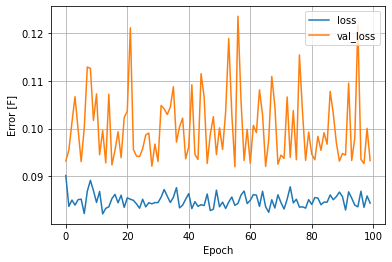

In [15]:
plot_loss(history)

In [16]:
test_results = {}

test_results['feature_model'] = feature_model.evaluate(
    test_features['phi_x'],
    test_labels, verbose=0)

In [17]:
x = tf.linspace(0.0, 250, 251)
y = feature_model.predict(x)

8/8 [==============================] - 0s 814us/step


In [18]:
def plot_feature(x, y):
  plt.scatter(train_features['phi_x'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlim([0, 360])
  plt.ylim([-0.5, 6.2])
  plt.xlabel('phi_x')
  plt.ylabel('F')
  plt.legend()

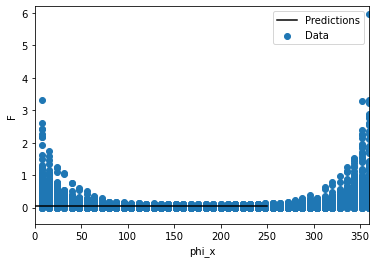

In [19]:
plot_feature(x, y)

### Linear regression with multiple inputs

Model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) defined earlier and adapted to the whole dataset:

In [20]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [21]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 52ms/step


array([[-2.265],
       [ 2.07 ],
       [-0.818],
       [ 0.575],
       [ 0.261],
       [ 0.352],
       [-0.476],
       [-1.892],
       [ 1.962],
       [ 1.467]], dtype=float32)

In [22]:
linear_model.layers[1].kernel #check that kernel weights (m) have a shape of (12, 1)

<tf.Variable 'dense_1/kernel:0' shape=(12, 1) dtype=float32, numpy=
array([[ 0.527],
       [ 0.614],
       [-0.37 ],
       [-0.197],
       [-0.093],
       [ 0.258],
       [ 0.598],
       [ 0.459],
       [-0.163],
       [ 0.216],
       [ 0.265],
       [-0.464]], dtype=float32)>

Train for 100 epochs:

In [23]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [24]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 25.2 s, sys: 3.36 s, total: 28.6 s
Wall time: 41.2 s


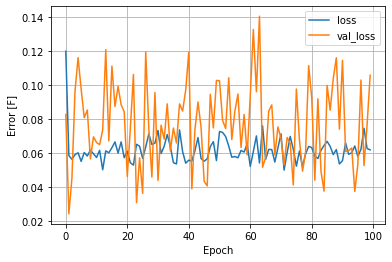

In [25]:
plot_loss(history)

Lower training and validation error than the one input regression model! (~0.02 difference)

In [26]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `feature_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [27]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

DNN model with only `'phi_x'` as input and `feature_normalizer` (defined earlier) as the normalization layer:

In [28]:
dnn_feature_model = build_and_compile_model(feature_normalizer)

In [29]:
dnn_feature_model.summary() # Note: this model has quite a few more trainable parameters than linear models

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [30]:
%%time
history = dnn_feature_model.fit(
    train_features['phi_x'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 30.2 s, sys: 4.49 s, total: 34.7 s
Wall time: 23.6 s


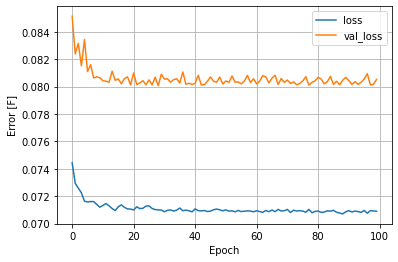

In [31]:
plot_loss(history)

In [32]:
x = tf.linspace(0.0, 250, 251)
y = dnn_feature_model.predict(x)

8/8 [==============================] - 0s 1ms/step


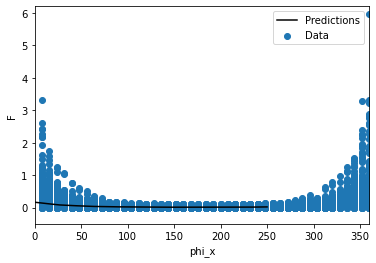

In [33]:
plot_feature(x, y)

In [34]:
test_results['dnn_feature_model'] = dnn_feature_model.evaluate(
    test_features['phi_x'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

In [35]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 12)               25        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                832       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,082
Trainable params: 5,057
Non-trainable params: 25
_________________________________________________________________


In [36]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 31.9 s, sys: 5.12 s, total: 37 s
Wall time: 24.2 s


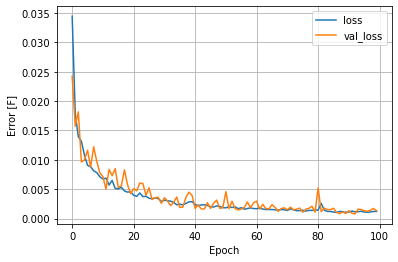

In [37]:
plot_loss(history)

In [38]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

In [39]:
pd.DataFrame(test_results, index=['Mean absolute error [F]']).T

,Mean absolute error [F]
feature_model,0.084420
linear_model,0.105694
dnn_feature_model,0.074525
dnn_model,0.001364


These results match the validation error observed during training.

### Predictions

Predictions made with the `dnn_model` on the test set and the lowss is then reviewed:

65/65 [==============================] - 0s 730us/step


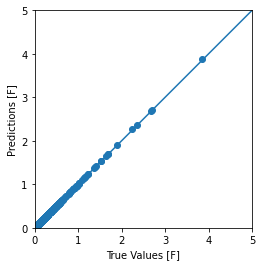

In [40]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [F]')
plt.ylabel('Predictions [F]')
lims = [0, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Model predicts reasonably well!

Error distribution:

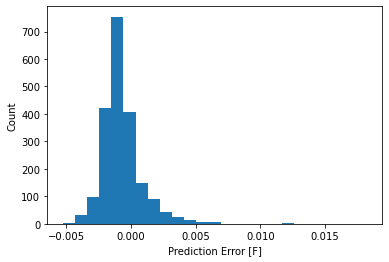

In [41]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [F]')
_ = plt.ylabel('Count')

In [42]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


Reloading the model:

In [43]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [44]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
feature_model,0.084420
linear_model,0.105694
dnn_feature_model,0.074525
dnn_model,0.001364
reloaded,0.001364
